#### Setup

In [1]:
import os
import tarfile
import urllib

import numpy as np
import pandas as pd

from zlib import crc32
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

%load_ext autoreload
%autoreload 2


#### Get the Data

In [2]:
DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/'
HOUSING_PATH = os.path.join('datasets', 'housing')
HOUSING_URL = DOWNLOAD_ROOT + 'datasets/housing/housing.tgz'


def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, 'housing.tgz')
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()


def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)


In [3]:
fetch_housing_data()
df = load_housing_data()
df.head(5)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
df['ocean_proximity'].value_counts()


<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

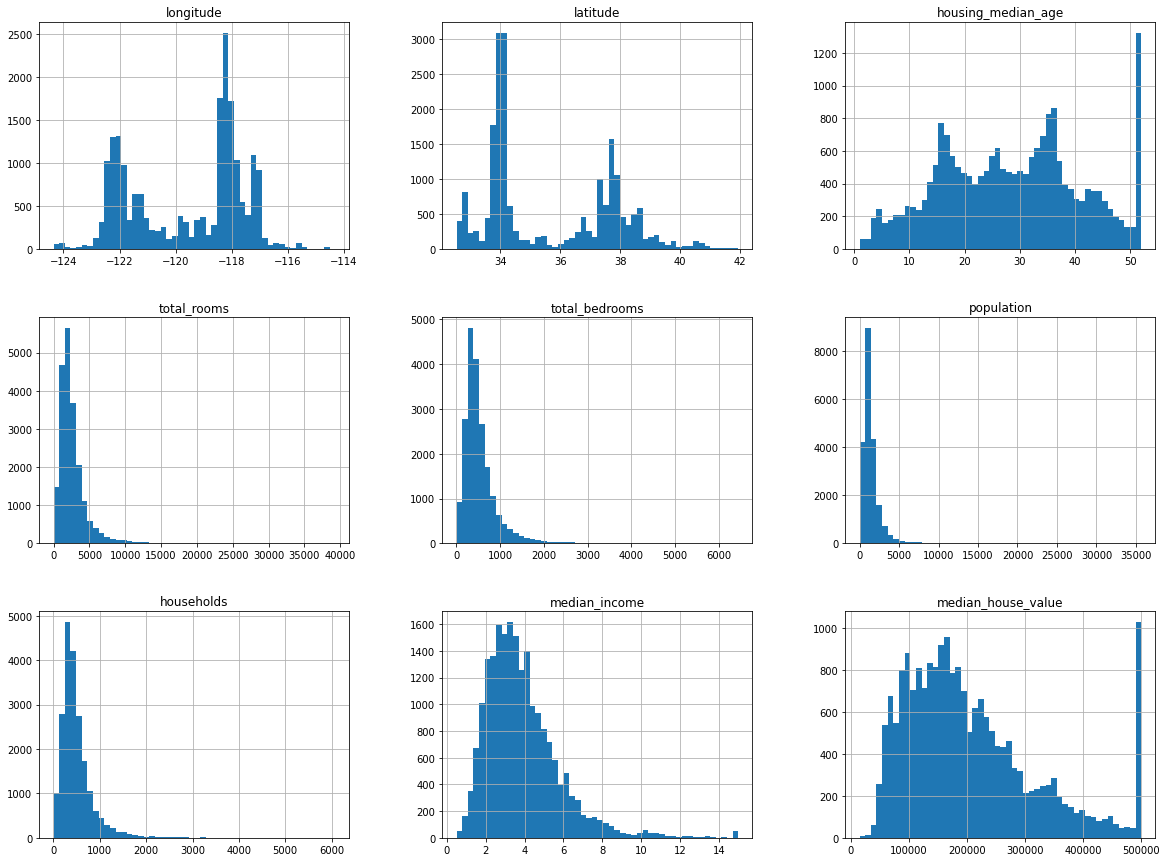

In [6]:
df.hist(bins=50, figsize=(20, 15))
plt.show()


#### Create a Test Set

In [7]:
def split_train_test(df, test_ratio):
    shuffled_indices = np.random.permutation(len(df))
    test_set_size = int(len(df) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return df.iloc[train_indices], df.iloc[test_indices]


train_set, test_set = split_train_test(df, test_ratio=0.2)


In [8]:
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2 ** 32


def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]


df_id = df.reset_index()  # adds an index column
train_set, test_set = split_train_test_by_id(df_id, test_ratio=0.2, id_column='index')


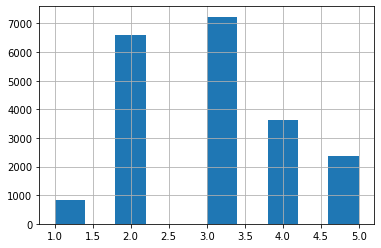

In [9]:
df['income_cat'] = pd.cut(df['median_income'], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])

df['income_cat'].hist()
plt.show()


In [10]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=101)
for train_index, test_index in split.split(df, df['income_cat']):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

strat_test_set['income_cat'].value_counts() / len(strat_test_set)


3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [11]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)


In [12]:
df = strat_train_set.copy()


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

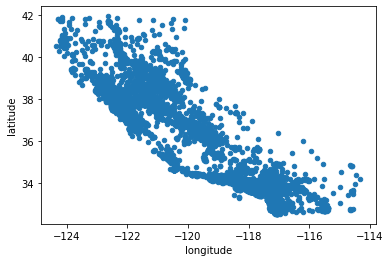

In [13]:
df.plot(kind='scatter', x='longitude', y='latitude')


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

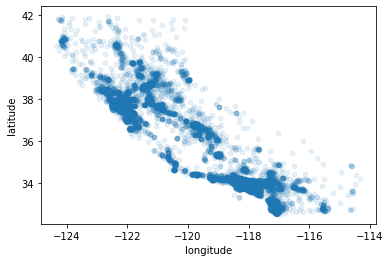

In [14]:
df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)


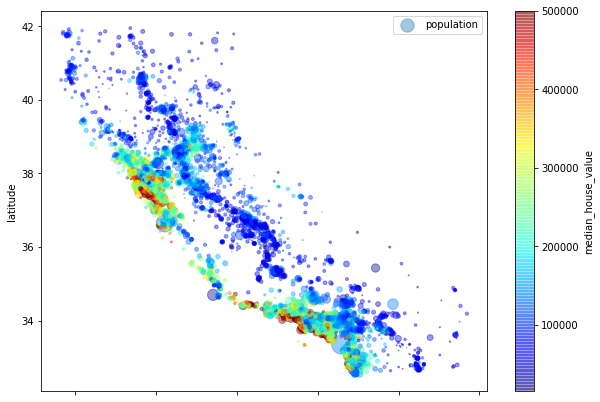

In [15]:
df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
        s=df["population"] / 100, label="population", figsize=(10, 7),
        c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
        )
plt.legend()


In [16]:
# Download the California image
PROJECT_ROOT_DIR = "."
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "end_to_end_project")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('./images/end_to_end_project/california.png',
 <http.client.HTTPMessage at 0x7f9c82278b50>)

In [17]:
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", 'end_to_end_project')


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Saving figure california_housing_prices_plot


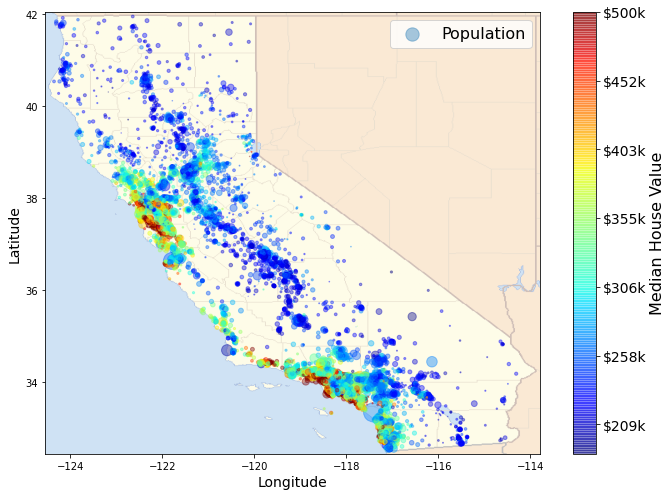

In [18]:
california_img = mpimg.imread(os.path.join(images_path, filename))
ax = df.plot(kind="scatter", x="longitude", y="latitude", figsize=(10, 7),
             s=df['population'] / 100, label="Population",
             c="median_house_value", cmap=plt.get_cmap("jet"),
             colorbar=False, alpha=0.4)
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = df["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values / prices.max())
cbar.ax.set_yticklabels(["$%dk" % (round(v / 1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

In [19]:
corr_matrix = df.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)


median_house_value    1.000000
median_income         0.688861
total_rooms           0.131705
housing_median_age    0.106367
households            0.062986
total_bedrooms        0.046211
population           -0.026423
longitude            -0.047033
latitude             -0.143429
Name: median_house_value, dtype: float64

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

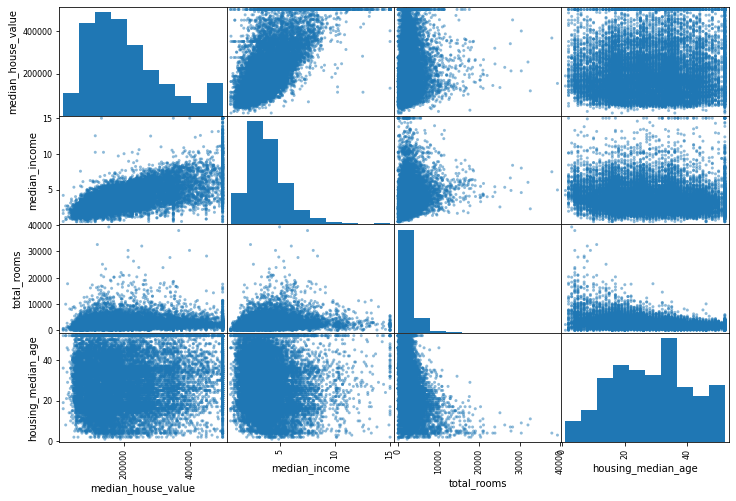

In [20]:
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
pd.plotting.scatter_matrix(df[attributes], figsize=(12, 8))


<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

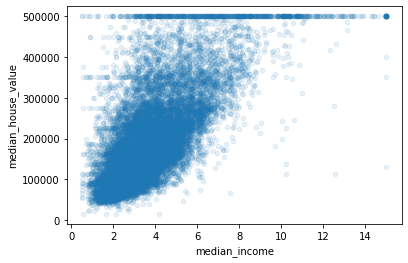

In [21]:
df.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)


##### Feature Engineering

In [22]:
df['rooms_per_household'] = df['total_rooms'] / df['households']
df['bedrooms_per_room'] = df['total_bedrooms'] / df['total_rooms']
df['population_per_household'] = df['population'] / df['households']


In [23]:
corr_matrix = df.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)


median_house_value          1.000000
median_income               0.688861
rooms_per_household         0.148335
total_rooms                 0.131705
housing_median_age          0.106367
households                  0.062986
total_bedrooms              0.046211
population_per_household   -0.022186
population                 -0.026423
longitude                  -0.047033
latitude                   -0.143429
bedrooms_per_room          -0.252651
Name: median_house_value, dtype: float64

#### Prepare the Data for Machine Learning Algorithms

In [24]:
X_train = strat_train_set.drop('median_house_value', axis=1)
y_train = strat_train_set['median_house_value'].copy()


##### Data Cleaning

In [25]:
imputer = SimpleImputer(strategy='median')


In [26]:
# Drop qualitative features
df_num = df.drop('ocean_proximity', axis=1)


In [27]:
imputer.fit(df_num)


SimpleImputer(strategy='median')

In [28]:
imputer.statistics_


array([-1.18500000e+02,  3.42600000e+01,  2.90000000e+01,  2.12700000e+03,
        4.34000000e+02,  1.16500000e+03,  4.09000000e+02,  3.53715000e+00,
        1.79350000e+05,  5.22660176e+00,  2.03453237e-01,  2.81735597e+00])

In [29]:
df_num.median().values


array([-1.18500000e+02,  3.42600000e+01,  2.90000000e+01,  2.12700000e+03,
        4.34000000e+02,  1.16500000e+03,  4.09000000e+02,  3.53715000e+00,
        1.79350000e+05,  5.22660176e+00,  2.03453237e-01,  2.81735597e+00])

In [30]:
X = imputer.transform(df_num)

df_tr = pd.DataFrame(X, columns=df_num.columns, index=df_num.index)


In [31]:
# Handling text and ordinal features
df_cat = df[['ocean_proximity']]
df_cat.head(10)


,ocean_proximity
7716,<1H OCEAN
15085,<1H OCEAN
4897,<1H OCEAN
7390,<1H OCEAN
17041,NEAR OCEAN
12619,INLAND
5348,<1H OCEAN
6085,<1H OCEAN
5634,NEAR OCEAN
15409,<1H OCEAN


In [32]:
ordinal_encoder = OrdinalEncoder()
df_cat_encoded = ordinal_encoder.fit_transform(df_cat)
df_cat_encoded[:10]


array([[0.],
       [0.],
       [0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [0.],
       [4.],
       [0.]])

In [33]:
ordinal_encoder.categories_


[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [34]:
cat_encoder = OneHotEncoder()
df_cat_1hot = cat_encoder.fit_transform(df_cat)
df_cat_1hot


<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [35]:
df_cat_1hot.toarray()


array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.]])

In [36]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [37]:
rooms_idx, bedrooms_idx, population_idx, households_idx = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):  # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        rooms_per_household = X[:, rooms_idx] / X[:, households_idx]
        population_per_household = X[:, population_idx] / X[:, households_idx]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_idx] / X[:, rooms_idx]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]

        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
df_extra_attr = attr_adder.transform(df.values)


#### Feature Scaling